## Randomized Network Learnability 

In [34]:
import pandas as pd
import numpy as np
import functools as ft
import itertools as it
import multiprocessing as mp
import scipy.sparse as sp

import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from gensim import corpora
from collections import defaultdict
from gensim.models import TfidfModel
from collections import Counter
from copy import copy

from tools import learnabilityHelpers as lh

## this suppresses the warnings encountered during normal use of Matthew's Corr Coeff from sklearn
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### We don't need to generate new processes -- use from original

In [154]:
go_file = '../data/goData/kinase_go_processes.csv'
go_dir = './'

# create a dictionary with our datasets
go_data_dict, go_transform_dict = lh.get_go_data_dict(go_file=go_file)

Now, we need to get our cluster data and make a few DataFrames with the clusters and go_annotations attached

## Control 1: Randomized Network

In [73]:
cluster_dir = '../results/randomizedResults/'

spinglass_file = 'consensus_spinglass.txt'
spinglass_data_dict = {key:lh.add_cluster_labels(cluster_dir+spinglass_file,
                                  val) for key, val in go_data_dict.items()}

fastgreedy_file = 'fastgreedy_clusters.txt'
fastgreedy_data_dict = {key:lh.add_cluster_labels(cluster_dir+fastgreedy_file,
                                  val) for key, val in go_data_dict.items()}

eigen_file = 'consensus_eigenvector.txt'
eigen_data_dict = {key:lh.add_cluster_labels(cluster_dir+eigen_file,
                                  val) for key, val in go_data_dict.items()}

labelprop_file = 'consensus_label_propagation.txt'
labelprop_dict = {key:lh.add_cluster_labels(cluster_dir+labelprop_file,
                                  val) for key, val in go_data_dict.items()}

walktrap_file = 'consensus_walktrap.txt'
walktrap_dict = {key:lh.add_cluster_labels(cluster_dir+walktrap_file,
                                  val) for key, val in go_data_dict.items()}

louvain_super_file = 'louvain_clusters.txt'
louvain_super_dict = {key:lh.add_cluster_labels(cluster_dir+louvain_super_file,
                                  val) for key, val in go_data_dict.items()}

louvain_sub_file = 'louvain_small_clusters.txt'
louvain_sub_dict = {key:lh.add_cluster_labels(cluster_dir+louvain_sub_file,
                                  val) for key, val in go_data_dict.items()}

infomap_file = 'consensus_infomap.txt'
infomap_dict = {key:lh.add_cluster_labels(cluster_dir+infomap_file,
                                  val) for key, val in go_data_dict.items()}

edge_betweenness_file = 'edge_betweenness_community_clusters.txt'
edge_betweenness_dict = {key:lh.add_cluster_labels(cluster_dir+edge_betweenness_file,
                                  val) for key, val in go_data_dict.items()}

method_list = ['spinglass', 'fastgreedy', 'eigen', 'labelprop', 'walktrap', 'louvain_super', 'louvain_sub', 'infomap', 'edge_between']
method_dicts = [spinglass_data_dict, fastgreedy_data_dict, eigen_data_dict, labelprop_dict, walktrap_dict, louvain_super_dict, louvain_sub_dict, infomap_dict, edge_betweenness_dict]
composite_data_dict = {x:y for x,y in zip(method_list, method_dicts)}

Dropped  0 kinases due to zero length post-processing
Dropped  5 kinases due to zero length post-processing
Dropped  36 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  5 kinases due to zero length post-processing
Dropped  36 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  5 kinases due to zero length post-processing
Dropped  36 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  5 kinases due to zero length post-processing
Dropped  36 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  5 kinases due to zero length post-processing
Dropped  36 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  5 kinases due to zero length post-processing
Dropped  36 kinases due to zero length post-processing
Dropped  0 kinases due

Now, let's import a few linear classifiers

In [74]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.naive_bayes import ComplementNB as CNB

svm = SVC(kernel='linear', class_weight='balanced')
cnb = CNB()

classifiers = [svm, cnb]
clf_names = [str(clf.__class__).split('.')[-1][0:-2] for clf in classifiers]

And get the accuracy and MCC scores for our datasets

In [75]:
validation_kwargs = {'n_run':5, 'metrics':['accuracy', 'matthews'], 'parallel':min(5, mp.cpu_count()-1), 'test_size':0.3}
results_dict = {}

for method in composite_data_dict.keys():
    # we may need to check for clusterings with a single cluster; this isn't learnable
    if len(composite_data_dict[method]['go']['cluster'].unique())<= 2:
        results_dict[method] = {str(clf.__class__).split('.')[-1][0:-2]:0 for key, val in composite_data_dict[method].items() for clf in classifiers}
    else:
        results_dict[method] = {str(clf.__class__).split('.')[-1][0:-2]:lh.validate_learnability(dat_df=val, clf=clf, **validation_kwargs) for key, val in composite_data_dict[method].items() for clf in classifiers}


In [76]:
mean_results = {}
std_results = {}

for method in results_dict.keys():
    if len(composite_data_dict[method]['go']['cluster'].unique())<= 2:
        mean_results[method] = {key:[0,0] for key in clf_names}
        std_results[method] = {key:[0,0] for key in clf_names}
    else:
        mean_results[method] = {key:np.mean(np.vstack(map(np.array, results_dict[method][key])), axis=0) for key in results_dict[method].keys()}
        std_results[method] = {key:np.std(np.vstack(map(np.array, results_dict[method][key])), axis=0) for key in results_dict[method].keys()}


In [77]:
cluster_descriptions = {}
mod_scores = {}

mod_table = pd.read_csv('../results/randomizedResults/clustering_modularity_results.txt', sep='\t')
mod_scores = {x:y for x,y in zip(method_list, mod_table.loc[0].values)}

for method in method_list:
    # grab the cluster list from one of the datatype dictionaries
    cluster_list = composite_data_dict[method]['go']['cluster']
    
    # create a counter to get the count data
    clust_counter = Counter(cluster_list)
    
    # count and number of cluster data
    cluster_counts = list(clust_counter.values())
    n_clust = len(cluster_counts)
    
    # mean and std of cluster size
    size_mean = np.round(np.mean(cluster_counts), 1)
    size_std = np.round(np.std(cluster_counts), 1)
    
    # largest and smallest cluster size
    size_max = np.max(cluster_counts) 
    
    # update size and modularity data
    cluster_descriptions[method] = {'N_clust':n_clust, 'Mean clust size':size_mean, 'Clust size std.':size_std, 'Largest clust size':size_max}
    cluster_descriptions[method].update({'Modularity':np.round(mod_scores[method],3)})
    
    # update learnability
    # clf-specific results
    #cluster_descriptions[method].update({clf_name+' accuracy':np.round(mean_results[method][clf_name],2)[0] for clf_name in clf_names})
    #cluster_descriptions[method].update({clf_name+' MCC':np.round(mean_results[method][clf_name],2)[1] for clf_name in clf_names})
    # composite results
    cluster_descriptions[method].update({'Composite Accuracy':np.round(np.mean([mean_results[method][clf_name][0] for clf_name in clf_names]),2)})
    cluster_descriptions[method].update({'Comp Acc std.':np.round(np.mean([std_results[method][clf_name][0] for clf_name in clf_names]),2)})
    cluster_descriptions[method].update({'Composite MCC':np.round(np.mean([mean_results[method][clf_name][1] for clf_name in clf_names]),2)})
    cluster_descriptions[method].update({'Comp MCC std.':np.round(np.mean([std_results[method][clf_name][1] for clf_name in clf_names]),2)})
    
results_df = pd.DataFrame.from_dict(cluster_descriptions, orient='index').sort_values(by='Composite MCC', ascending=False)

results_df.columns = ['No. Clusters', 'Mean size', 'sigma size', 'Largest clust',
       'Mod', 'Comp Acc', 'sigma Comp Acc', 'Comp MCC',
       'sigma Comp MCC']

display(results_df)

,No. Clusters,Mean size,sigma size,Largest clust,Mod,Comp Acc,sigma Comp Acc,Comp MCC,sigma Comp MCC
edge_between,179,2.9,25.0,337,0.002,0.52,0.03,0.09,0.02
louvain_super,10,51.7,36.3,114,0.164,0.20,0.03,0.05,0.04
fastgreedy,7,73.9,43.4,133,0.009,0.21,0.03,0.03,0.04
louvain_sub,44,11.8,23.2,99,0.153,0.13,0.05,0.03,0.03
eigen,9,57.4,49.2,157,0.121,0.21,0.02,0.02,0.02
infomap,2,258.5,256.5,515,0.000,0.00,0.00,0.00,0.00
labelprop,1,517.0,0.0,517,0.066,0.00,0.00,0.00,0.00
spinglass,447,1.2,0.7,10,0.153,0.00,0.00,-0.00,0.00
walktrap,143,3.6,10.1,84,0.000,0.08,0.03,0.00,0.02


We can see that:

> 1. Leading Eigenvalues does not produce valid clusterings as while accuracy is high, MCC is relatively poor
> 2. Fast Greedy appears to have the best learnability, but we should remeber that Consensus Spinglass has many more classes
> 3. Filtering/TFIDF does not negatively impact the learnability, so we can ignore the rare labels in our analysis


## Convert pandas.DataFrame to TeX


In [78]:
tex_string = results_df.to_latex()
print(tex_string)

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  No. Clusters &  Mean size &  sigma size &  Largest clust &    Mod &  Comp Acc &  sigma Comp Acc &  Comp MCC &  sigma Comp MCC \\
\midrule
edge\_between  &           179 &        2.9 &        25.0 &            337 &  0.002 &      0.52 &            0.03 &      0.09 &            0.02 \\
louvain\_super &            10 &       51.7 &        36.3 &            114 &  0.164 &      0.20 &            0.03 &      0.05 &            0.04 \\
fastgreedy    &             7 &       73.9 &        43.4 &            133 &  0.009 &      0.21 &            0.03 &      0.03 &            0.04 \\
louvain\_sub   &            44 &       11.8 &        23.2 &             99 &  0.153 &      0.13 &            0.05 &      0.03 &            0.03 \\
eigen         &             9 &       57.4 &        49.2 &            157 &  0.121 &      0.21 &            0.02 &      0.02 &            0.02 \\
infomap       &             2 &      258.5 &       256.5 &            515 &  0.000 &  

## Generate Intra-Supercluster Analysis of Louvain Subclusters


In [79]:
louvain_combined_dict = {key:louvain_super_dict[key].drop('GO Labels', axis=1).merge(louvain_sub_dict[key], on='names', how='left', suffixes = ['_super', '_sub'])
                         for key, val in go_data_dict.items()}


In [80]:
# this is a map of the subclusters in each supercluster
super_sub_dict = louvain_combined_dict['go'].groupby('cluster_super')['cluster_sub'].agg(set)
display(super_sub_dict)

cluster_super
1          {32, 1, 3, 10, 22, 31}
2                      {8, 21, 6}
3                 {16, 2, 29, 38}
4     {39, 9, 11, 17, 18, 19, 23}
5             {33, 7, 14, 25, 30}
6                {24, 42, 28, 13}
7          {34, 4, 5, 40, 12, 15}
8                    {41, 27, 36}
9                    {35, 43, 37}
10                   {26, 20, 44}
Name: cluster_sub, dtype: object

In [81]:
louvain_combined_dict.keys()

dict_keys(['go', 'freq', 'tfidf'])

In [82]:
validation_kwargs = {'n_run':5, 'metrics':['accuracy', 'matthews'], 'parallel':mp.cpu_count()-1, 'test_size':0.3}
intra_results_dict = {}

# iterate over superclusters
for sup_ in super_sub_dict.keys():
    # proceed if more than one subcluster in each supercluster
    if len(super_sub_dict[sup_]) > 1:
        for sub_ in super_sub_dict[sup_]:
            intra_results_dict[sup_] = {str(clf.__class__).split('.')[-1][0:-2]:lh.validate_learnability(dat_df=val[val.cluster_super==sup_], clf=clf, Y_col_name='cluster_sub', **validation_kwargs) for key, val in louvain_combined_dict.items() for clf in classifiers}


In [83]:
validation_kwargs = {'n_run':5, 'metrics':['confusion'], 'parallel':max(mp.cpu_count()-1, 5), 'test_size':0.3}
conf_intra_results_dict = {}

# add linear unbalanced svc to the classifiers for visualization
classifiers_ext = {str(clf.__class__).split('.')[-1][0:-2]:clf for clf in classifiers}
unbal_svm = SVC(kernel='linear')
classifiers_ext['unbalSVM'] = unbal_svm 

# iterate over superclusters
for sup_ in super_sub_dict.keys():
    # proceed if more than one subcluster in each supercluster
    if len(super_sub_dict[sup_]) > 1:
        for sub_ in super_sub_dict[sup_]:
            conf_intra_results_dict[sup_] = {clf_key:lh.validate_learnability(dat_df=val[val.cluster_super==sup_], clf=clf, Y_col_name='cluster_sub', **validation_kwargs) for key, val in louvain_combined_dict.items() for clf_key, clf in classifiers_ext.items()}


In [84]:
## normalize the heatmap by row
for sup_ in conf_intra_results_dict.keys():
    for learning_algo in conf_intra_results_dict[sup_].keys():
        # aggregate into average confusion matrix -- not integral do to random sampling size differences
        composite_score = np.mean(conf_intra_results_dict[sup_][learning_algo], axis=0)
        row_sums = np.sum(composite_score, axis=1)
        # normalize
        for i in range(composite_score.shape[0]):
            # add 1 for stability
            composite_score[i,:] = composite_score[i,:] / (1 if row_sums[i] == 0 else row_sums[i])
            
        conf_intra_results_dict[sup_][learning_algo] = composite_score

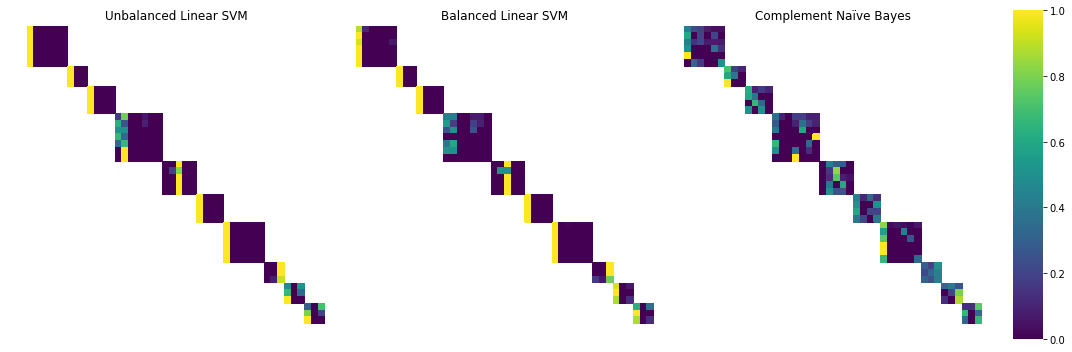

In [85]:
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(15,5), gridspec_kw={'width_ratios':[10,10,10,1]})
for ax in axes[:3]:
    ax.axis('off')

## put complementNB on the right    
intra_heatmap_matrix = np.zeros((len(set(louvain_combined_dict['go'].cluster_sub)),len(set(louvain_combined_dict['go'].cluster_sub))))
intra_heatmap_mask = np.ones_like(intra_heatmap_matrix)

running_index = 0
for sup_ in super_sub_dict.keys():
    num_sub_in_sup = len(super_sub_dict[sup_])
    
    if num_sub_in_sup > 1:
        intra_heatmap_matrix[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = conf_intra_results_dict[sup_]['ComplementNB']
    intra_heatmap_mask[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = 0    
        
    running_index += num_sub_in_sup
    
sns.heatmap(intra_heatmap_matrix, mask=intra_heatmap_mask, cmap=plt.cm.viridis, square=True, cbar=True, ax=axes[2], cbar_ax=axes[3])


## put balanced SVC in the middle
intra_heatmap_matrix = np.zeros_like(intra_heatmap_matrix)
intra_heatmap_mask = np.ones_like(intra_heatmap_matrix)

running_index = 0
for sup_ in super_sub_dict.keys():
    num_sub_in_sup = len(super_sub_dict[sup_])
    
    if num_sub_in_sup > 1:
        intra_heatmap_matrix[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = conf_intra_results_dict[sup_]['SVC']
    intra_heatmap_mask[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = 0    
        
    running_index += num_sub_in_sup
    

sns.heatmap(intra_heatmap_matrix, mask=intra_heatmap_mask, cmap=plt.cm.viridis, square=True, cbar=False, ax=axes[1])

### put unbalanced svc on the left
intra_heatmap_matrix = np.zeros_like(intra_heatmap_matrix)
intra_heatmap_mask = np.ones_like(intra_heatmap_matrix)

running_index = 0
for sup_ in super_sub_dict.keys():
    num_sub_in_sup = len(super_sub_dict[sup_])
    
    if num_sub_in_sup > 1:
        intra_heatmap_matrix[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = conf_intra_results_dict[sup_]['unbalSVM']
    intra_heatmap_mask[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = 0    
        
    running_index += num_sub_in_sup
    
sns.heatmap(intra_heatmap_matrix, mask=intra_heatmap_mask, cmap=plt.cm.viridis, square=True, cbar=False, ax=axes[0])


## layout and titles
plt.tight_layout()
axes[0].set_title('Unbalanced Linear SVM')
axes[1].set_title('Balanced Linear SVM')
axes[2].set_title('Complement Naïve Bayes')

plt.savefig('../viz/images/pdf/randomized_intracluster_learnability_comparison.pdf')
plt.savefig('../viz/images/png/randomized_intracluster_learnability_comparison.png')

plt.show()

### Use Existing GO Slim whitelist

In [124]:
go_slim_data_dict, go_slim_transform_dict = lh.get_go_data_dict(go_file='../data/goData/kinase_go_slim_processes.csv')

In [125]:
go_slim_data_dict['freq'].iloc[1].shape

(247,)

In [126]:
missing = list(set(go_slim_data_dict['go'].index) - set(go_slim_data_dict['freq'].index))

missing_df = pd.DataFrame([[[0]*len(go_slim_data_dict['freq'].iloc[0])]], index=missing)
go_slim_data_dict['freq'] = go_slim_data_dict['freq'].append(missing_df)
#missing_df

In [127]:
louv = copy(louvain_super_dict['go'])
louv.columns = ['cluster_super', 'GO Labels']
louv['cluster_sub'] = louvain_sub_dict['go']['cluster']
louv = louv[['cluster_super', 'cluster_sub', 'GO Labels']]
louv.head()

,cluster_super,cluster_sub,GO Labels
names,,,
MST1R,7,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
YES1,7,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
TYRO3,2,6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
FGR,1,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
SRC,1,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [128]:
slim_test = copy(pd.DataFrame(go_slim_data_dict['freq']))
slim_test.columns = ['GO Labels']
slim_test['cluster'] = pd.Series(slim_test.index, index=slim_test.index).map(louv.cluster_super.to_dict())
slim_test.head()

,GO Labels,cluster
MKNK1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8
CDKL4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6
BTK,"[0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",3
BUB1B,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7
WNK4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5


In [129]:
louv_X, __, louv_y, __ = lh.get_tts(dat=slim_test,test_size=0)
louv_slim_super_characterizers = [SVC(kernel='linear', class_weight='balanced'), CNB()]
for clf in louv_slim_super_characterizers:
    clf.fit(louv_X, louv_y)
    
slim_feat = list(go_slim_transform_dict['freq'].classes_)#.to_list()
slim_feat[:50]

['BMP signaling pathway',
 'DNA damage induced protein phosphorylation',
 'DNA repair',
 'DNA-templated',
 'ERK1 and ERK2 cascade',
 'Fc-epsilon receptor signaling pathway',
 'MAPK cascade',
 'Mullerian duct regression',
 'MyD88-dependent toll-like receptor signaling pathway',
 'MyD88-independent toll-like receptor signaling pathway',
 'Rho protein signal transduction',
 'T cell receptor signaling pathway',
 'Wnt signaling pathway',
 'actin cytoskeleton organization',
 'actin cytoskeleton reorganization',
 'activation of GTPase activity',
 'activation of JUN kinase activity',
 'activin receptor signaling pathway',
 'adherens junction assembly',
 'angiogenesis',
 'animal organ morphogenesis',
 'anterior/posterior pattern specification',
 'apoptotic mitochondrial changes',
 'apoptotic process',
 'apoptotic signaling pathway',
 'attachment of spindle microtubules to kinetochore',
 'axon guidance',
 'blood coagulation',
 'branching involved in blood vessel morphogenesis',
 'branching morph

In [130]:
louv_slim_super_characterizers[0].score(louv_X, louv_y)

0.5957446808510638

### Cluster Comparison

In [106]:
louv_sup = louv['cluster_super']
#spin = spinglass_clusters.set_index('names').drop('GO Labels', axis=1)
fast = pd.read_csv(cluster_dir+fastgreedy_file, sep='\t',index_col=0)['cluster']

Below is the fast_greedy membership of each c_spinglass cluster

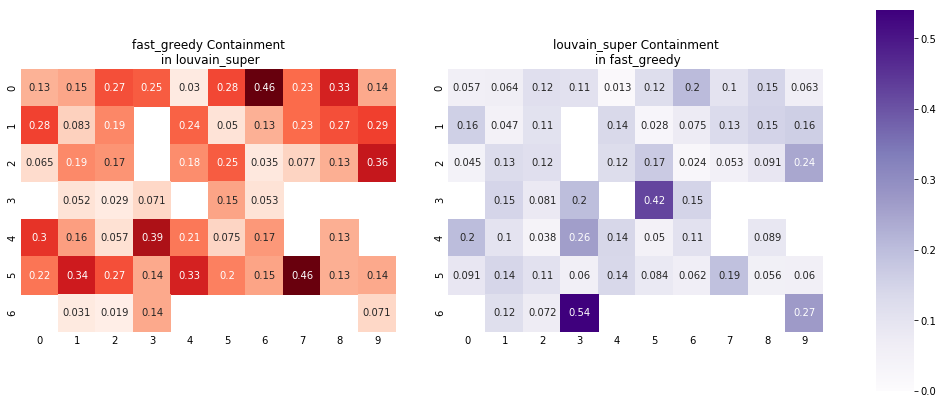

In [107]:
import seaborn as sns
from sklearn.metrics.cluster import contingency_matrix

fig, axes = plt.subplots(ncols=3, figsize=(16,7), sharey=False, gridspec_kw={'width_ratios':[10,10,1]})

# fast_greedy membership of louv
cont_mat = pd.DataFrame(contingency_matrix(fast, louv_sup))
cont_mat = cont_mat.divide(other = cont_mat.sum(axis=0),axis = 1)
cont_mat_mask = cont_mat.values == 0

axes[0].set_title('fast_greedy Containment\n in louvain_super', size=12)
axes[0].tick_params(axis='both', length=0)
sns.heatmap(cont_mat, ax=axes[0], cmap='Reds', cbar=False, square=True, annot=True, mask=cont_mat_mask)

# louv membership of fast_greedy
cont_mat_rev = pd.DataFrame(contingency_matrix(fast, louv_sup))
cont_mat_rev = cont_mat.divide(other = cont_mat.sum(axis=1),axis = 0)
cont_mat_rev_mask = cont_mat_rev.values == 0

axes[1].set_title('louvain_super Containment\n in fast_greedy', size=12)
axes[1].tick_params(axis='both', length=0)
sns.heatmap(cont_mat_rev, ax=axes[1], cmap='Purples', cbar_ax=axes[2], square=True, annot=True, mask=cont_mat_rev_mask)

plt.savefig('../viz/images/pdf/randomized_louv_fast_compare.pdf')
plt.savefig('../viz/images/png/randomized_louv_fast_compare.png')

plt.show()

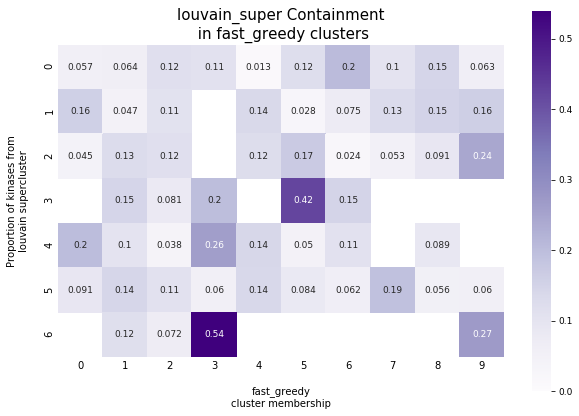

In [108]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,7))

plt.rc('font', **{'family':'normal', 'size':9})    
ax.set_title('louvain_super Containment\n in fast_greedy clusters', size=15)
ax.tick_params(axis='both', length=0)

sns.heatmap(cont_mat_rev, ax=ax, cmap='Purples',square=True, annot=True, mask=cont_mat_rev_mask)
plt.xlabel('\nfast_greedy\ncluster membership')
plt.ylabel('Proportion of kinases from\nlouvain supercluster\n')

plt.savefig('../viz/images/pdf/randomized_louvain_in_fast_greedy.pdf')
plt.savefig('../viz/images/png/randomized_louvain_in_fast_greedy.png')

plt.show()

Below is the louvain membership of each fast_greedy cluster

Rand correlation matrix

In [109]:
clusts = {}
for method in method_list:
    cl = composite_data_dict[method]['go']
    clusts[method] = np.squeeze(cl.drop(['GO Labels'], axis=1).values)

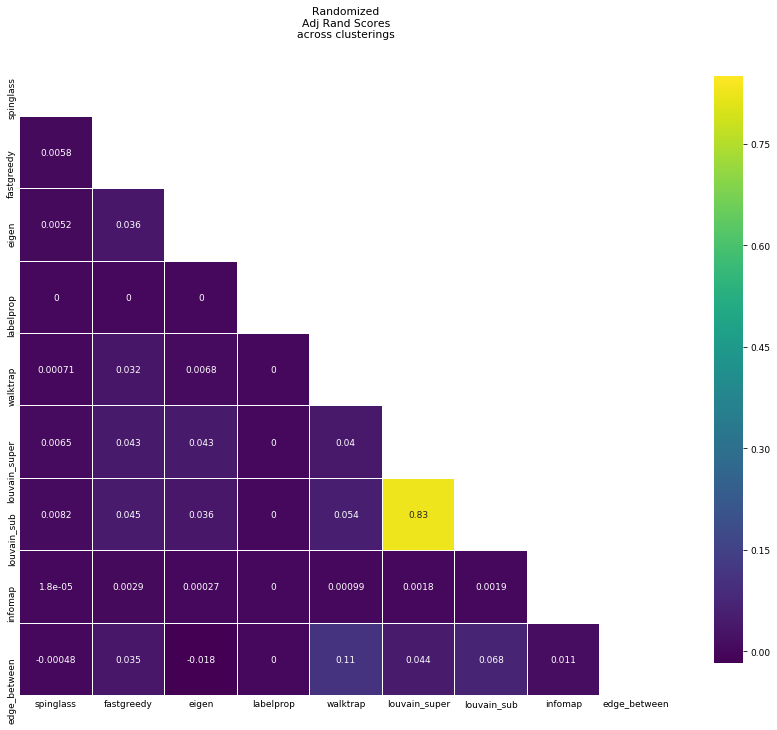

In [110]:
from sklearn.metrics import adjusted_rand_score as rand
rand_corr_matrix = np.zeros((len(clusts), len(clusts)))

fig, ax = plt.subplots(figsize=(15,12))

for i in range(len(clusts)):
    for j in range(len(clusts)):
        rand_corr_matrix[i,j] = rand(clusts[method_list[i]], clusts[method_list[j]])

mask = np.zeros_like(rand_corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
        
ax.tick_params(axis='both', length=0)
ax.set_title('Randomized\nAdj Rand Scores\nacross clusterings')
sns.heatmap(rand_corr_matrix,mask=mask,cmap='viridis', square=True, vmax=.85, cbar_kws={"shrink": .9}, linewidths=0.01, xticklabels=method_list,yticklabels=method_list, ax = ax, annot=True)

plt.savefig('../viz/images/pdf/randomized_adj_rand_scores.pdf')
plt.savefig('../viz/images/png/randomized_adj_rand_scores.png')

plt.show()

## Control 2: Randomized GO Annotations
#### Use the same network as in 04_GOLearnability, but randomly shuffle the training predictor covariates

In [155]:
ind = go_data_dict['go'].index
vals = go_data_dict['go'].values
for key in go_data_dict.keys():
    ind = go_data_dict[key].index
    vals = go_data_dict[key].values
    
    # set the same random seed to preserve across 'go', 'freq', and 'tfidf'
    np.random.seed(1920)
    np.random.shuffle(vals)
    
    go_data_dict[key] = pd.DataFrame(pd.Series(vals, index=ind, name='GO Labels'))

In [156]:
cluster_dir = '../results/weighted/'

spinglass_file = 'consensus_spinglass.txt'
spinglass_data_dict = {key:lh.add_cluster_labels(cluster_dir+spinglass_file,
                                  val) for key, val in go_data_dict.items()}

fastgreedy_file = 'fastgreedy_clusters.txt'
fastgreedy_data_dict = {key:lh.add_cluster_labels(cluster_dir+fastgreedy_file,
                                  val) for key, val in go_data_dict.items()}

eigen_file = 'consensus_eigenvector.txt'
eigen_data_dict = {key:lh.add_cluster_labels(cluster_dir+eigen_file,
                                  val) for key, val in go_data_dict.items()}

labelprop_file = 'consensus_label_propagation.txt'
labelprop_dict = {key:lh.add_cluster_labels(cluster_dir+labelprop_file,
                                  val) for key, val in go_data_dict.items()}

walktrap_file = 'consensus_walktrap.txt'
walktrap_dict = {key:lh.add_cluster_labels(cluster_dir+walktrap_file,
                                  val) for key, val in go_data_dict.items()}

louvain_super_file = 'louvain_clusters.txt'
louvain_super_dict = {key:lh.add_cluster_labels(cluster_dir+louvain_super_file,
                                  val) for key, val in go_data_dict.items()}

louvain_sub_file = 'louvain_small_clusters.txt'
louvain_sub_dict = {key:lh.add_cluster_labels(cluster_dir+louvain_sub_file,
                                  val) for key, val in go_data_dict.items()}

infomap_file = 'consensus_infomap.txt'
infomap_dict = {key:lh.add_cluster_labels(cluster_dir+infomap_file,
                                  val) for key, val in go_data_dict.items()}

edge_betweenness_file = 'edge_betweenness_community_clusters.txt'
edge_betweenness_dict = {key:lh.add_cluster_labels(cluster_dir+edge_betweenness_file,
                                  val) for key, val in go_data_dict.items()}

method_list = ['spinglass', 'fastgreedy', 'eigen', 'labelprop', 'walktrap', 'louvain_super', 'louvain_sub', 'infomap', 'edge_between']
method_dicts = [spinglass_data_dict, fastgreedy_data_dict, eigen_data_dict, labelprop_dict, walktrap_dict, louvain_super_dict, louvain_sub_dict, infomap_dict, edge_betweenness_dict]
composite_data_dict = {x:y for x,y in zip(method_list, method_dicts)}

Dropped  0 kinases due to zero length post-processing
Dropped  5 kinases due to zero length post-processing
Dropped  36 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  5 kinases due to zero length post-processing
Dropped  36 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  5 kinases due to zero length post-processing
Dropped  36 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  5 kinases due to zero length post-processing
Dropped  36 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  5 kinases due to zero length post-processing
Dropped  36 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  5 kinases due to zero length post-processing
Dropped  36 kinases due to zero length post-processing
Dropped  0 kinases due

In [157]:
validation_kwargs = {'n_run':5, 'metrics':['accuracy', 'matthews', 'prf'], 'parallel':max(1, mp.cpu_count()-1), 'test_size':0.3}
results_dict = {}

for method in composite_data_dict.keys():
    results_dict[method] = {str(clf.__class__).split('.')[-1][0:-2]:lh.validate_learnability(dat_df=val, clf=clf, **validation_kwargs) for key, val in composite_data_dict[method].items() for clf in classifiers}

# break the class-wise precision, recall, and f-score results off
prf_results = {}
for method in composite_data_dict.keys():
    prf_results[method] = {}
    for key in results_dict[method].keys():
        # convert the multiple scores to lists
        results_dict[method][key] = list(zip(*results_dict[method][key]))
        
        # pop the last item in the list, the prf score
        prf_results[method][key] = results_dict[method][key].pop(-1)    


In [158]:
mean_results = {}
std_results = {}

for method in method_list:
    mean_results[method] = {key:[np.mean(np.array(score_arr)) for score_arr in results_dict[method][key]] for key in results_dict[method].keys()}
    std_results[method] = {key:[np.std(np.array(score_arr)) for score_arr in results_dict[method][key]] for key in results_dict[method].keys()}
    
print('Accuracy, MCC')
for method in method_list:
    print(method+' | '+str(mean_results[method]['SVC']))
        
print('\nAcc Std, MCC Std')    
for method in method_list:
    print(method+' | '+str(std_results[method]['SVC']))

Accuracy, MCC
spinglass | [0.08413793103448276, 0.003514209832629546]
fastgreedy | [0.23034482758620692, 0.020787206930333778]
eigen | [0.23448275862068968, 0.0077367531632830805]
labelprop | [0.9696551724137932, -0.005548668498086542]
walktrap | [0.42206896551724143, 0.05842132801937407]
louvain_super | [0.16827586206896553, 0.017922624758214274]
louvain_sub | [0.11172413793103449, 0.024992591114973765]
infomap | [0.15172413793103448, 0.0071490990437368005]
edge_between | [0.07448275862068965, -0.004789628949871392]

Acc Std, MCC Std
spinglass | [0.048452877435173236, 0.00768581138679404]
fastgreedy | [0.02709914855777724, 0.022544591109629447]
eigen | [0.008723524579774843, 0.013805475165917215]
labelprop | [0.008275862068965481, 0.006825188720893497]
walktrap | [0.08118035293551537, 0.06160710476682731]
louvain_super | [0.020735581211548833, 0.01780081898692956]
louvain_sub | [0.01819435304589368, 0.01883247305759991]
infomap | [0.15371731548419346, 0.0201874337346861]
edge_between 

In [159]:
mod_table = pd.read_csv('../results/weighted/clustering_modularity_results.txt', sep='\t')
mod_table

,fast_greedy,spinglass,eigen,walktrap,label,louvain,small_louvain,infomap,edge_between
0,0.279008,0.26696,0.229506,0.06015,0.005479,0.314593,0.300422,0.174903,0.16289


In [160]:
cluster_descriptions = {}
mod_scores = {}

mod_scores = {x:y for x,y in zip(method_list, mod_table.loc[0].values)}

for method in method_list:
    # grab the cluster list from one of the datatype dictionaries
    cluster_list = composite_data_dict[method]['go']['cluster']
    
    # create a counter to get the count data
    clust_counter = Counter(cluster_list)
    
    # count and number of cluster data
    cluster_counts = list(clust_counter.values())
    n_clust = len(cluster_counts)
    
    # mean and std of cluster size
    size_mean = np.round(np.mean(cluster_counts), 1)
    size_std = np.round(np.std(cluster_counts), 1)
    
    # largest and smallest cluster size
    size_max = np.max(cluster_counts) 
    
    # update size and modularity data
    cluster_descriptions[method] = {'N_clust':n_clust, 'Mean clust size':size_mean, 'Clust size std.':size_std, 'Largest clust size':size_max}
    cluster_descriptions[method].update({'Modularity':np.round(mod_scores[method],4)})
    
    # update learnability
    # clf-specific results
    #cluster_descriptions[method].update({clf_name+' accuracy':np.round(mean_results[method][clf_name],2)[0] for clf_name in clf_names})
    #cluster_descriptions[method].update({clf_name+' MCC':np.round(mean_results[method][clf_name],2)[1] for clf_name in clf_names})
    # composite results
    cluster_descriptions[method].update({'Composite Accuracy':np.round(np.mean([mean_results[method][clf_name][0] for clf_name in clf_names]),4)})
    cluster_descriptions[method].update({'Comp Acc std.':np.round(np.mean([std_results[method][clf_name][0] for clf_name in clf_names]),4)})
    cluster_descriptions[method].update({'Composite MCC':np.round(np.mean([mean_results[method][clf_name][1] for clf_name in clf_names]),4)})
    cluster_descriptions[method].update({'Comp MCC std.':np.round(np.mean([std_results[method][clf_name][1] for clf_name in clf_names]),4)})
    
results_df = pd.DataFrame.from_dict(cluster_descriptions, orient='index').sort_values(by='Composite MCC', ascending=False)

results_df.columns = ['No. Clusters', 'Mean size', 'sigma size', 'Largest clust',
       'Mod', 'Comp Acc', 'sigma Comp Acc', 'Comp MCC',
       'sigma Comp MCC']

display(results_df)
print(results_df.to_latex())

,No. Clusters,Mean size,sigma size,Largest clust,Mod,Comp Acc,sigma Comp Acc,Comp MCC,sigma Comp MCC
walktrap,12,43.1,94.2,331,0.0055,0.4228,0.0643,0.0503,0.0593
fastgreedy,10,51.7,50.7,133,0.2670,0.2241,0.0284,0.0335,0.0269
louvain_sub,26,19.9,27.9,123,0.3004,0.1152,0.0142,0.0210,0.0152
louvain_super,9,57.4,35.8,142,0.3146,0.1600,0.0169,0.0108,0.0160
spinglass,77,6.7,17.0,118,0.2790,0.0938,0.0324,0.0094,0.0119
eigen,5,103.4,43.8,185,0.2295,0.2324,0.0188,0.0069,0.0266
infomap,52,9.9,33.1,240,0.1749,0.1834,0.0885,0.0003,0.0224
labelprop,4,129.2,217.5,506,0.0602,0.8303,0.0268,-0.0008,0.0375
edge_between,205,2.5,11.3,143,0.1629,0.0924,0.0524,-0.0051,0.0194
